In [1]:
import numpy as np
import gvar as gv
import sys
from pathlib import Path
import os
import io
import yaml
import platform
import pprint
import matplotlib
import matplotlib.pyplot as plt
import warnings  
warnings.simplefilter(action="default")
warnings.filterwarnings('ignore') 

In [2]:
cwd = Path(os.getcwd())
# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)
# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels
# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd'
else:
    base_dir = '/home/gmoney/lqcd'

data_dir = os.path.join(base_dir, "data")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")

/home/gmoney/lqcd/nucleon_sigma


In [3]:
import xpt.fit_analysis as fa 
import xpt.fit_routine as fit
import xpt.i_o as i_o
import xpt.priors as priors
import xpt.fpi_fit
import xpt.mpi_fit

In [4]:
# from priors import prior
prior = priors.prior

In [5]:
gv.load('../data/w0_a_results.p')
w0_a = gv.load('../data/a_fm_results.p').values()

In [6]:
#FIND BETTER WAY TO LOAD IN MODEL VIA CLI PROMPT#

f = open('../xpt/models_nucleon.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
    #print(keys)
model_info = {}
for item in models.values():
        #smodel_info = item['m_p:s_lo:d_lo:x_lo:l_lo:fpi']
        #model_info = item['eps_p:s_n4lo:d_n4lo:x_n4lo:l_n4lo:fpi']
        #model_info = item['eps_p:taylor:l_lo']
        model_info = item['eps_p:taylor:l_lo:x_lo']
        #model_info = item['eps_p:taylor:l_n2lo']
        #model_info = item['eps_p:taylor:l_n2lo:x_lo']
        #model_info = item['eps_p:l_n2lo:xpt_lo']
        #model_info = item['eps_p:taylor:l_lo:x_lo']
        model_info_sigma = item['eps_p:taylor:l_n2lo:d_lo:sigma_pi']
        model_info_fpi = item['fpi:l_n2lo:d_n2lo:x_n2lo']
        #model_info_fpi = item['fpi:l4_bar']
        model_info_simul = item['simul:taylor:l_lo:x_lo:d_lo']
        model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']

#print(model_info)

In [7]:
input_output = i_o.InputOutput()
data = input_output.get_data(scheme='w0_org',units='phys',include_phys=False)
new_prior = input_output.make_prior(data,prior)
phys_point_data = input_output.get_data_phys_point()

In [8]:
fit_mp = fit.fit_routine(prior=new_prior, data=data, model_info=model_info,phys_point_data=phys_point_data)
fit_mp_out = fit_mp.fit
print(fit_mp_out)
m_proton_deriv_ = fit_mp.get_fitfcn(p=fit_mp_out.p, data=phys_point_data)
print(m_proton_deriv_)
m_proton_deriv = m_proton_deriv_['proton'][0]

# extrap_mass_phys = extrap_mass['proton'][0] / phys_point_data['lam_chi']
# print(extrap_mass_phys)
m_pi = phys_point_data['m_pi']
lam_chi = phys_point_data['lam_chi']
m_proton = fit_mp_out.p['m_{proton,0}']
e_pi = m_pi / lam_chi
sigma = m_pi**2 *gv.deriv(m_proton, m_pi**2)
l3 = gv.gvar('3.53(26)')
l4 = gv.gvar('4.73(10)')
term_0 = lam_chi * e_pi/2 * m_proton_deriv
term_1 = lam_chi * e_pi/2 * m_proton_deriv * e_pi**2*(5/2 - l3/2 - 2*l4 )
term_2 = e_pi**2 * m_proton*(l4-1)
sigma = term_0 + term_1 + term_2
# print(term_0,term_1,term_2,sigma)
sigma_analytic = (e_pi/2 * (1 + e_pi**2*(5/2 - l3/2 - 2*l4 )) *m_proton_deriv) * lam_chi
print('sigma w/ gv.deriv:',sigma)
print('sigma analytic:',sigma_analytic)

Least Square Fit:
  chi2/dof [dof] = 1.5 [15]    Q = 0.11    logGBF = 28.871

Parameters:
     m_{proton,0}      0.827 (16)      [     0.90 (40) ]  
     b_{proton,2}       1.3 (1.9)      [     2.0 (2.0) ]  
           l4_bar      -2.4 (1.4)      [     4.0 (4.0) ]  *
     b_{proton,4}      -0.2 (2.0)      [     0.0 (2.0) ]  
     d_{proton,a}      -0.48 (17)      [     0.0 (5.0) ]  
    d_{proton,aa}       1.44 (56)      [     0.0 (5.0) ]  
    d_{proton,al}       1.28 (96)      [     0.0 (5.0) ]  
g_{proton,proton}       0.93 (65)      [     1.3 (5.0) ]  
 g_{proton,delta}       1.5 (5.0)      [     1.5 (5.0) ]  
      m_{delta,0}       2.0 (1.0)      [     2.0 (1.0) ]  
     a_{proton,4}      -0.1 (5.0)      [     0.0 (5.0) ]  
     g_{proton,4}       0.9 (1.9)      [     0.0 (2.0) ]  
         eps_pi 0    0.11620 (33)      [  0.11619 (33) ]  
                1    0.18197 (37)      [  0.18197 (37) ]  
                2    0.24617 (44)      [  0.24619 (44) ]  
                3    0.2

In [9]:
fit_fpi = fpi_fit.fit_routine(prior=new_prior, data=data, model_info=model_info_fpi)
fit_fpi_out = fit_fpi.fit
extrap_fpi = fpi_fit.Fpi(datatag='Fpi',model_info=model_info_fpi)
extrap = extrap_fpi.fitfcn(p=fit_fpi_out.p)
#print(fit_fpi_out)
print( '\n','ens:',ensembles,'\n','extrapolation:',extrap, '\n',fit_fpi_out.format(True))
#print('extrapolation:','\n','M_0/lam_chi:',extrap_mass, '\n','M_0(meV):',extrap_mass_phys,'\n',fit_fpi_out)

NameError: name 'fpi_fit' is not defined

In [ ]:
fit_mp = fit.fit_routine(prior=new_prior, data=data, model_info=model_info)
fit_mp_out = fit_mp.fit
print('extrapolation:','\n','M_0/lam_chi:',extrap_mass, '\n','M_0(meV):',extrap_mass_phys,'\n',fit_mp_out)

extrapolation: 
 M_0/lam_chi: {'proton': 0.8123(47)} 
 M_0(meV): 939.8(8.0) 
 Least Square Fit:
  chi2/dof [dof] = 2.1 [15]    Q = 0.0071    logGBF = 30.606

Parameters:
   m_{proton,0}      0.789 (10)      [     0.90 (40) ]  
   b_{proton,2}       0.26 (68)      [     2.0 (2.0) ]  
         l4_bar      -0.70 (36)      [     4.0 (4.0) ]  *
   b_{proton,4}      -1.0 (1.9)      [     0.0 (2.0) ]  
   b_{proton,6}      -0.2 (2.0)      [     0.0 (2.0) ]  
   d_{proton,a}      0.024 (21)      [     0.0 (5.0) ]  
       eps_pi 0    0.11620 (33)      [  0.11619 (33) ]  
              1    0.18197 (37)      [  0.18197 (37) ]  
              2    0.24618 (44)      [  0.24619 (44) ]  
              3    0.26951 (58)      [  0.26949 (58) ]  
              4    0.29820 (54)      [  0.29819 (54) ]  
              5    0.11359 (33)      [  0.11360 (33) ]  
              6    0.18219 (44)      [  0.18220 (44) ]  
              7    0.24484 (51)      [  0.24486 (51) ]  
              8    0.27061 (69)

In [ ]:
fit_mpi = mpi_fit.fit_routine(prior=new_prior, data=data, model_info=model_info_mpi)
fit_mpi_out = fit_mpi.fit
extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
extrap = extrap_mpi.fitfcn(p=fit_mpi_out.p)
#print(fit_fpi_out)
print( '\n','ens:',ensembles,'\n','extrapolation:',extrap, '\n',fit_mpi_out.format(True))

KeyError: 'l_3'

KeyError: 'eps_sigma_pi_n'

In [ ]:
reload(io)
m_pi = phys_point_data['m_pi']
lam_chi = phys_point_data['lam_chi']
m_proton = fit_mp_out.p['m_{proton,0}']
e_pi = m_pi / lam_chi
sigma = m_pi**2 *gv.deriv(m_proton, m_pi**2)
l3 = gv.gvar('3.53(26)')
l4 = gv.gvar('4.73(10)')
term_0 = lam_chi * e_pi/2 * m_proton_deriv
term_1 = lam_chi * e_pi/2 * m_proton_deriv * e_pi**2*(5/2 - l3/2 - 2*l4 )
term_2 = e_pi**2 * m_proton*(l4-1)
sigma = term_0 + term_1 + term_2
print(term_0,term_1,term_2,sigma)
sigma_analytic = (e_pi/2 * (1 + e_pi**2*(5/2 - l3/2 - 2*l4 )) *m_proton_deriv) * lam_chi
print('sigma w/ gv.deriv:',sigma)
print('sigma analytic:',sigma_analytic)


NameError: name 'm_proton_deriv' is not defined

In [ ]:
def plot_parameters(xparam='ens', yparam='l4'):
        # if yparam is None:
        #     yparam = 'eps_proton'

    x = {}
    y = {}
    c = {}
    fit = {}

    #plt.axes([0.145,0.145,0.85,0.85])
        
    colors = {
        '06' : '#6A5ACD',
        '09' : '#51a7f9',
        '12' : '#70bf41',
        '15' : '#ec5d57',
    }
    for ens in ensembles:
        a = ens.split('m')[0]
        m = ens[3:7]

    for i in  range(len(ensembles)):
        for j, param in enumerate([xparam, yparam]):
            if param == 'mp':
                value = fit_mp_out.y['proton'][i]
                label = '$\epsilon_p$'

            elif param == 'eps_pi':
                value = fit_mp_out.p['eps_pi'][i]
                label = '$\epsilon_\pi$'

            elif param == 'eps2_a':
                value = fit_mp_out.p['eps2_a'][i]
                label = '$\epsilon_a^2$'

            elif param == 'l4':
                value = fit_fpi_out.p['l4_bar']
                label = '$l4$'
                print(value)

            elif param =='ens':
                value = a[i]
                label = str(a)

            # elif param == 'a':
            #     value = ensembles
            #     label = '$a$'

            
            if j == 0:
                x[i] = value
                xlabel = label
            elif j == 1:
                y[i] = value
                ylabel = label

    

    C = gv.evalcov(y)
        
    plt.plot(gv.mean(y), marker='o', mec='w')

        # C = gv.evalcov([x[i], y[i]])
        # eVe, eVa = np.linalg.eig(C)
        # for e, v in zip(eVe, eVa.T):
        #     plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
        #             [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
        #                 alpha=1.0, lw=2)
        #     plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
        #                 marker='o', mec='w', zorder=3)


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
        ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
    plt.grid()
    plt.xlabel(xlabel, fontsize = 24)
    plt.ylabel(ylabel, fontsize = 24)
    plt.axvline(gv.mean(phys_point_data['eps_pi']), ls='--', label='phys. point')

    fig = plt.gcf()
    plt.close()
    return fig

3.8(2.2)
3.8(2.2)


TypeError: object of type 'NoneType' has no len()

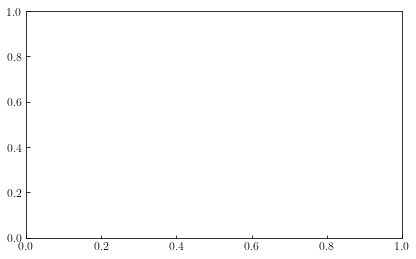

In [ ]:
plot_parameters(xparam='ens', yparam='l4')

3.8(2.2)
3.8(2.2)


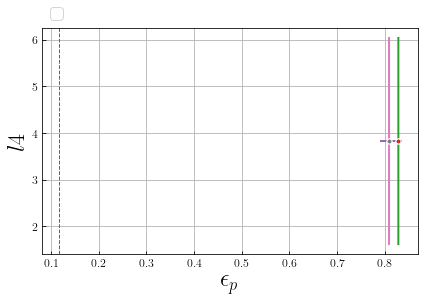

In [ ]:
plot_parameters(xparam='mp', yparam='l4')

In [ ]:
y_fit = fit_analysis.fitfcn(particle='proton')
np.repeat(y_fit,16)

{'m_{proton,0}': 0.8093(63), 'b_{proton,4}': 1.2(1.5), 'b_{proton,6}': 0.2(2.0), 'b_{proton,2}': 0.74(18), 'd_{proton,a}': -0.034(23), 'eps2_a': 0(0), 'a': 0(0), 'alpha_s': 0(0), 'L': inf(0), 'hbarc': 197.327(0), 'lam_chi': 1157.0(7.2), 'm_pi': 134.80(30), 'm_k': 494.20(30), 'eps_pi': 0.11651(77), 'eps_k': 0.4271(27), 'm_proton': 938.9187470(42), 'eps_proton': 0.8115(50), 'm_delta': 1232.0(2.0), 'eps_delta': 1.0648(68)}


array([0.8195(47), 0.8195(47), 0.8195(47), 0.8195(47), 0.8195(47),
       0.8195(47), 0.8195(47), 0.8195(47), 0.8195(47), 0.8195(47),
       0.8195(47), 0.8195(47), 0.8195(47), 0.8195(47), 0.8195(47),
       0.8195(47)], dtype=object)

In [ ]:
def plot_fit(xparam=None, yparam='mp'):
        if yparam is None:
            yparam = 'eps_proton'

        x = {}
        y = {}
        c = {}
        #fit = {}

        #plt.axes([0.145,0.145,0.85,0.85])
            
        colors = {
            '06' : '#6A5ACD',
            '09' : '#51a7f9',
            '12' : '#70bf41',
            '15' : '#ec5d57',
        }

        for i in  range(len(ensembles)):
            for j, param in enumerate([xparam, yparam]):
                if param == 'mp':
                    value = fit_mp_out.y['proton'][i]
                    label = '$\epsilon_p$'

                elif param == 'eps_pi':
                    value = fit_mp_out.p['eps_pi'][i]
                    label = '$\epsilon_\pi$'
                    #min,max linspace

                elif param == 'eps2_a':
                    value = fit_mp_out.p['eps2_a'][i]
                    label = '$\epsilon_a^2$'


                if j == 0:
                    x[i] = value
                    xlabel = label
                elif j == 1:
                    y[i] = value
                    ylabel = label
        min_max = lambda arr : (np.nanmin(arr), np.nanmax(arr))
        min_val, max_val = min_max(data['eps_pi'])

        eps_pi = np.linspace(gv.mean(min_val), gv.mean(max_val))

        posterior = {}
        posterior.update(fit_mp_out.p)
        posterior['eps_pi'] = eps_pi

        #y_fit = fit.fcn(posterior)['eps_proton']
        y_fit = fit_analysis.fitfcn(particle='proton')

        pm = lambda g, k : gv.mean(g) + k *gv.sdev(g)
        plt.fill_between(gv.mean(eps_pi), pm(y_fit, -1), pm(y_fit, +1))
        plt.show()
        
        print(y_fit,value)

       

        for i in range(len(ensembles)):
            C = gv.evalcov([x[i], y[i]])
            eVe, eVa = np.linalg.eig(C)
            for e, v in zip(eVe, eVa.T):
                plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                        [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
                         alpha=1.0, lw=2)
                plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                          marker='o', mec='w', zorder=3)


        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),
            ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
        plt.grid()
        plt.xlabel(xlabel, fontsize = 24)
        plt.ylabel(ylabel, fontsize = 24)
        plt.axvline(gv.mean(phys_point_data['eps_pi']), ls='--', label='phys. point')

        fig = plt.gcf()
        plt.close()
        return fig

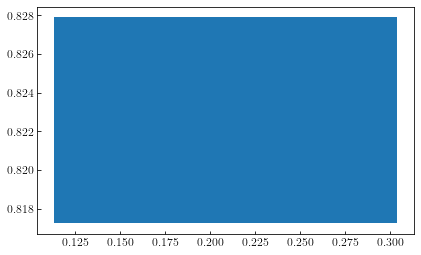

0.8226(53) 0.8860(36)


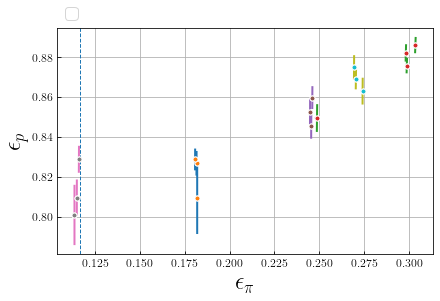

In [ ]:
plot_fit(xparam='eps_pi', yparam='mp')